In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#for Audio processing
from IPython.display import Audio
import librosa
import librosa.display

import joblib

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
#this is to ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
def play_librosa(wav_file, source='None'):
    
    print("WAV: ", wav_file)
    
    audio, sfreq = librosa.load(wav_file)
    time = np.arange(0, len(audio)) / sfreq

    print('Sample Rate:', sfreq)
    
    fig, ax = plt.subplots()
    ax.plot(time, audio)
    ax.set(xlabel='Time (sec)',  ylabel='Sound Amplitude')

    return Audio(data=audio, rate=sfreq)

## Extract feature

In [4]:
def librosa_features(data, sample_rate):
    
    '''this will create an array of some librosa features
    (e.g. zero_crossing_rate, root mean square energy, spectral centroid and rollfoof,
        chroma_stft, mfcc, rms, melspectrogram)
    concatenated for each audio'''
    
    
    result = np.array([])
    
   
    # Root Mean Square Value (one column, the average )
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # add as column 
    
     # Spectral Centroid (one column, the average )
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_centroid)) # stacking horizontally
    
        
     # Spectral Rolloff (one column, the average )
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, spectral_rolloff)) # add as column 
    
        
    
    # Zero Crossing Rate (one column, the average )
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # add as column 
    

    
    # Chroma_stft (12 columns)
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    
    # MFCC  (40 columns)
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally
      
    
    # MelSpectogram (128 columns)
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_basic_features(audio, sfreq):
    ''' get librosa features only for the test dataset '''
        
    #Trim leading and trailing silence from an audio signal.
    yt, index = librosa.effects.trim(audio)
    
    
    #librosa features
    res1 = librosa_features(yt, sfreq)

    return res1

## Load our model

In [15]:
loaded_model = joblib.load("./model/vote_model.bin")
sc = joblib.load('./model/vote_scaler.bin')
le = joblib.load('./model/vote_le.bin')

In [16]:
def predict(wav):
    
    emotion = ['angry','disgust','fear','happy','neutral','sad','surprised']
        
    audio, sfreq = librosa.load(wav)
    librosa_X = []
    librosa_X.append(get_basic_features(audio, sfreq))
    df_feature = pd.DataFrame(librosa_X)

    #scale
    x_scaled = sc.transform(pd.DataFrame(df_feature))
    
    #predict
    y_pred = loaded_model.predict(x_scaled)
    
    #return the prediction
    return le.inverse_transform(y_pred)

WAV:  ./test_audio/kyle_happy.wav
Sample Rate: 22050


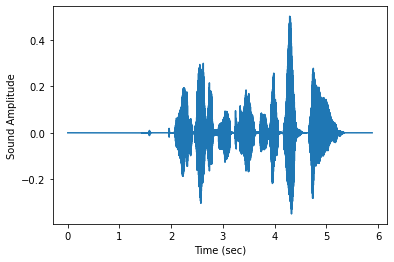

In [17]:
play_librosa('./test_audio/kyle_happy.wav')

In [18]:
predict('./test_audio/kyle_disgust.wav')

array(['happy'], dtype=object)

WAV:  ./test_audio/kyle_angry.wav
Sample Rate: 22050


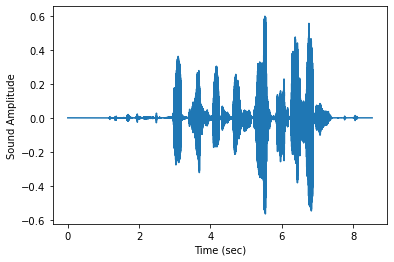

In [19]:
play_librosa('./test_audio/kyle_angry.wav')

In [20]:
predict('./test_audio/kyle_angry.wav')

array(['angry'], dtype=object)

WAV:  ./test_audio/random2.wav
Sample Rate: 22050


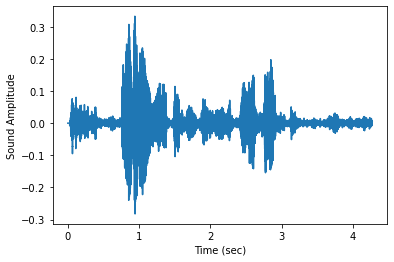

In [21]:
play_librosa('./test_audio/random2.wav')

In [22]:
predict('./test_audio/random2.wav')

array(['neutral'], dtype=object)